In [9]:
using Graphs, Plots, DelimitedFiles
import Statistics: mean
import StatsBase: sample
include("../mpdbp.jl")
include("../exact/montecarlo.jl")
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [26]:
q = q_glauber
T = 10
N = 8
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
h = zeros(N)
J = ones(ne(g))
β = 1.0
ising = Ising(g, J, h, β)
p⁰ = map(1:N) do i
    r = 0.95
    [r, 1-r]
end

# throw random observations
ϕ = [[ones(2) for t in 1:T] for i in 1:N]
nobs_node = 10
its = rand(collect(Iterators.product(1:N, 1:T)), nobs_node)
for (i, t) in its
    r = rand()
    ϕ[i][t] .= [r, 1-r]
end

# throw random pair observations
nobs_edge = 10
its = sample(collect(Iterators.product(edges(g), 1:T)), nobs_edge, replace=false)
O = map(its) do (e,t)
    i, j, ij = e
    (i, j, t, rand(2,2))
end

ψ = pair_observations_directed(O, IndexedBiDiGraph(gg), T, q)
ψ_nondirected = pair_observations_nondirected(O, g, T, q);

In [27]:
bp = mpdbp(ising, T, ϕ, ψ, p⁰)
cb = CB_BP(bp);

In [28]:
svd_trunc = TruncThresh(1e-2)
svd_trunc = TruncBond(7)
iters, cb = iterate!(bp, maxiter=100; svd_trunc, cb, tol=1e-3);

Running MPdBP: iter 15 	 Time: 0:00:53
  Δ:  0.0005164811291118454

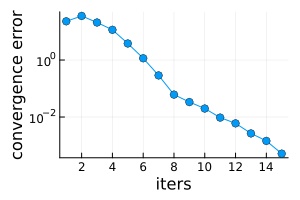

In [29]:
pl_err = plot(cb.Δs, ylabel="convergence error", xlabel="iters", m=:o, yaxis=:log10, 
    size=(300,200), label="")

In [30]:
b_bp = beliefs(bp)
m_bp = [[bbb[1]-bbb[2] for bbb in bb] for bb in b_bp];

In [31]:
ns = 10^5
sms = sample(bp, ns)
b_mc = marginals(sms)
m_mc = [[bbb[1] - bbb[2] for bbb in bb] for bb in b_mc];

SoftMargin sampling... 100%|█████████████████████████████| Time: 0:00:05


Glauber on random regular graph N=8, k=3, β=1.0.
10 random node observations, 10 random edge observations
Max matrix size: 7x7


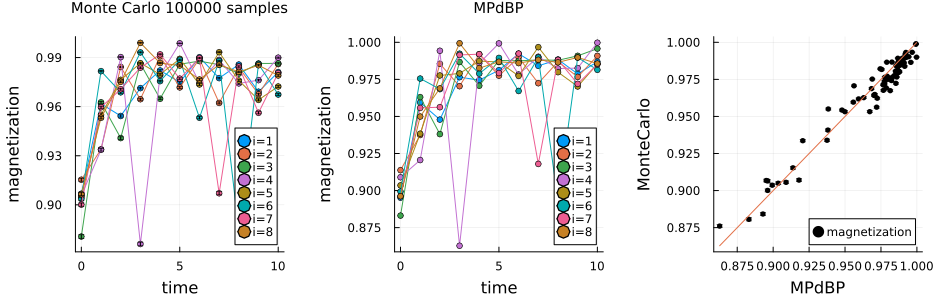

In [33]:
pl_mc = plot(xlabel="time", ylabel="magnetization", xticks=0:5:T, title="Monte Carlo $ns samples")
for i in 1:N
    plot!(pl_mc, 0:T, m_mc[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_bp = plot(xlabel="time", ylabel="magnetization", xticks=0:5:T, title="MPdBP")
for i in 1:N
    plot!(pl_bp, 0:T, m_bp[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_sc = scatter(reduce(vcat, m_bp), reduce(vcat, m_mc), xlabel="MPdBP", ylabel="MonteCarlo", 
    label="magnetization", ms=3, c=:black, legend=:outertopright)
plot!(identity, label="", size=(300,300))
println("Glauber on random regular graph N=$N, k=$k, β=$β.")
println("$nobs_node random node observations, $nobs_edge random edge observations")
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:bottomright, 
    margin=5Plots.mm, layout=(1,3))